In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.keras as keras

# Transfer Learning

A continuación veremos un ejemplo práctico de cómo cargar un modelo ya entrenado, reutilizar algunos de sus layers en otro modelo y congelarlos durante el entrenamiento. 

Hay varias formas en las que podemos conseguir un modelo pre-entrenado:
* Quizás encontramos un GitHub con un archivo de pesos para una dada arquitectura: En este caso debemos crear en keras un modelo con arquitectura idéntica, y cargar los pesos para cada Layer (la manera más dificil).
* Quizás quien lo implementó utilizó keras, y lo guardó en un ".h5", en cuyo caso basta con hacer  ``model = keras.load_model("modelo.h5")``.
* Algunas arquitecturas muy exitosas de computer vision se encuentran cargadas en ``keras.applications``.

A continuación instanciaremos una arquitectura [ResNet50](https://arxiv.org/abs/1512.03385), y cargaremos los pesos de esta red entrenada en el dataset ImageNet (que consiste en más de 14 millones de imágenes pertenecientes a más de 20 mil categorías). Esta arquitectura consta de 50 layers convolucionales con activaciones ReLu (intercalados con MaxPooling y BatchNormalization), y al final un único layer FullyConnected con 1000 neuronas de activación softmax, para clasificar en mil clases. Posee sobre 25 millones de parámetros.

Este ejemplo es una adaptación del presentado en la [guía de usuario de Keras.](https://keras.io/guides/transfer_learning/#an-endtoend-example-finetuning-an-image-classification-model-on-a-cats-vs-dogs) Una de las ventajas de esta librería es que está ampliamente documentada, y suplementada por ejemplos en su blog. Siempre que quieran comenzar con algún proyecto o tengan dudas sobre algún caso de uso, les recomiendo fuertemente consultar primero los ejemplos en su documentación.

## Datos

Utilizaremos un dataset de clasificación Gatos vs Perros

In [ ]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, orig_test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


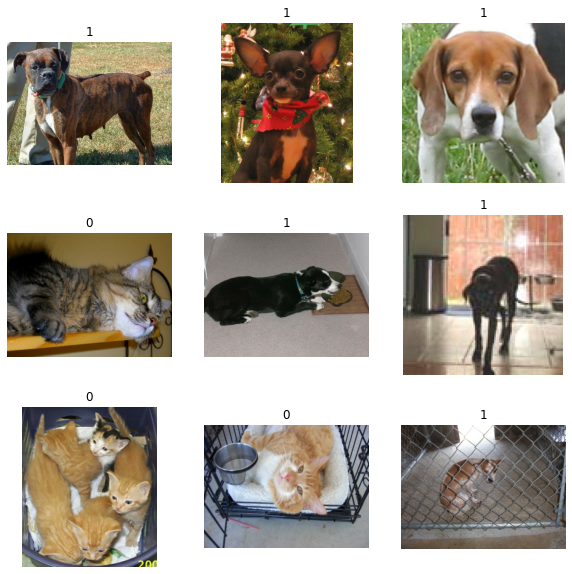

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

Las imagenes son de distintos tamaños, asi que las vamos a normalizar. Todas de tamaño 224x224, que es el tamaño que se utilizó para pre-entrenar la red.

In [ ]:
size = (224, 224)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = orig_test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

También la dividimos en Batches ya en el dataset, para que sea más eficiente la lectura de memoria

In [ ]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

## Data Augmentation

Añadimos un layer de aumentación de datos: Simplemente la volteamos horizontalmente, y hacemos una rotación aleatoria.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

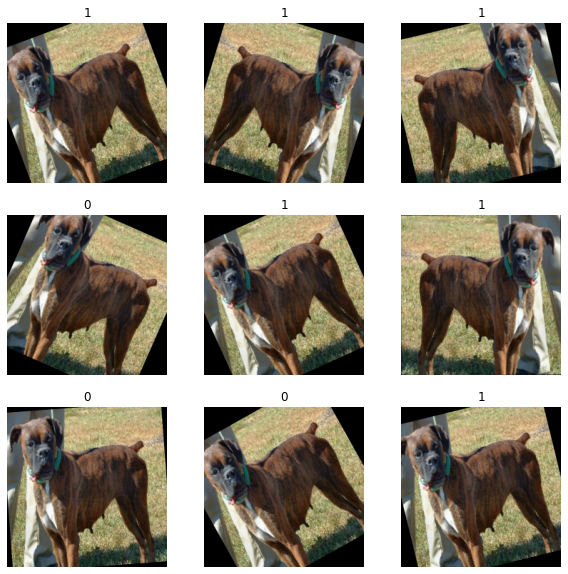

In [ ]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Modelo de Base

Cargamos el modelo de base. Con ``include_top=False`` le decimos que deje de lado el último layer (que contiene un layer softmax de mil neuronas), ya que nosotros utilizaremos uno propio.

In [ ]:
base_model = keras.applications.ResNet50(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    include_top=False,
)  # Do not include the ImageNet classifier at the top.


Congelamos los parámetros del modelo utilizando el atributo ``trainable``. Se puede aplicar layer por layer, pero si se aplica a un modelo automaticamente se lo hace a los layers que contiene.

In [ ]:
# Freeze the base_model
base_model.trainable = False

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

Ahora hacemos un layer de input, aplicamos el preprocesado de datos que usó ResNet al entrenarse, luego pasamos por la Resnet. Antes de salir aplicamos un GlobalAveragePooling, Dropout, y luego de eso nuestro clasificador: Una Densa de una neurona sigmoide (en realidad, no aplicamos la activación sino que la utilizamos directamente en la loss).

In [ ]:

# Create new model on top
inputs = keras.Input(shape= (224, 224, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Scale inputs
x = keras.applications.resnet.preprocess_input(x)


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

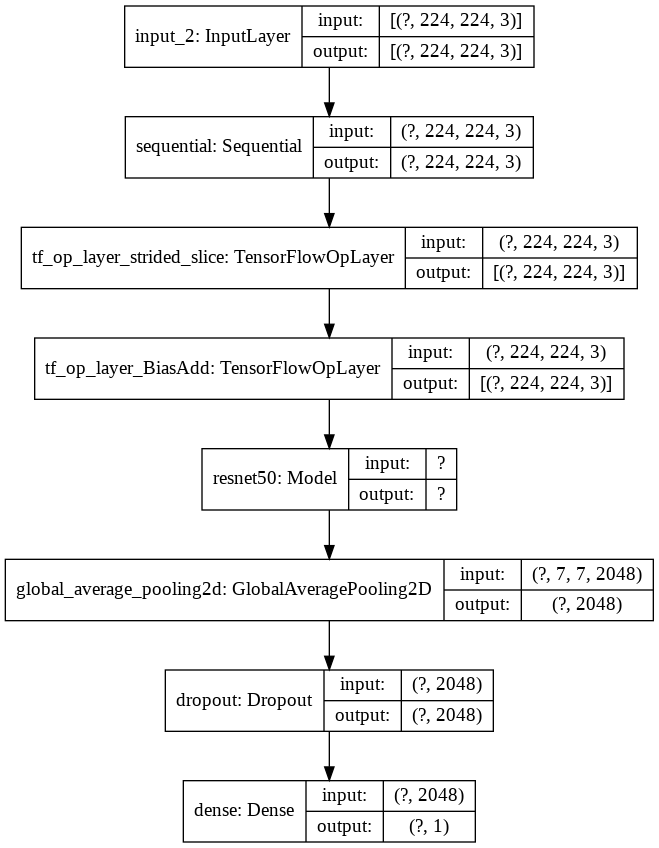

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

## Entrenamos

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 28s 98ms/step - loss: 0.1096 - binary_accuracy: 0.9578 - val_loss: 0.0463 - val_binary_accuracy: 0.9845
Epoch 2/20
291/291 [==============================] - 23s 80ms/step - loss: 0.0536 - binary_accuracy: 0.9782 - val_loss: 0.0427 - val_binary_accuracy: 0.9850
Epoch 3/20
291/291 [==============================] - 24s 81ms/step - loss: 0.0459 - binary_accuracy: 0.9837 - val_loss: 0.0350 - val_binary_accuracy: 0.9884
Epoch 4/20
291/291 [==============================] - 23s 81ms/step - loss: 0.0427 - binary_accuracy: 0.9837 - val_loss: 0.0401 - val_binary_accuracy: 0.9862
Epoch 5/20
291/291 [==============================] - 23s 81ms/step - loss: 0.0403 - binary_accuracy: 0.9855 - val_loss: 0.0318 - val_binary_accuracy: 0.9888
Epoch 6/20
291/291 [==============================] - 23s 81ms/step - loss: 0.0354 - binary_accuracy: 0.9862 - val_loss: 0.0339 - val_binary_accuracy: 0.9875
Epoch 7/20
291/291 [==============================] 

## Descongelamos y hacemos un fine-tuning

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

## Predecimos

Hacemos predicciones sobre un batch del test set

In [ ]:
preds = model.predict(test_ds.take(1))

Ahora, ploteemos 9 ejemplos de ese set y veamos como fue la clasificación.

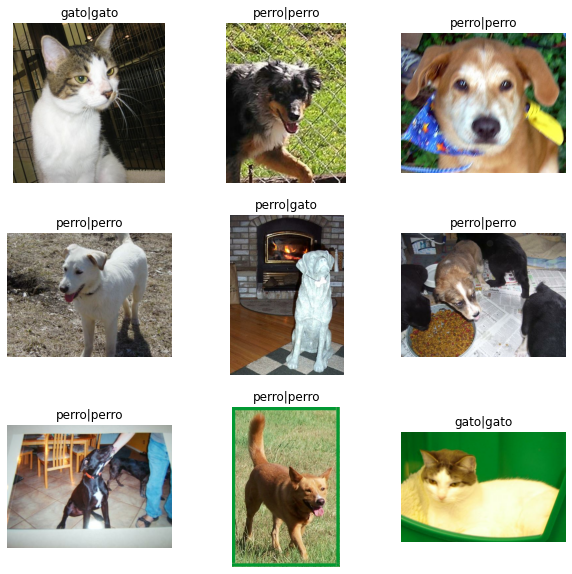

In [ ]:
import matplotlib.pyplot as plt
labels=['gato','perro']
plt.figure(figsize=(10, 10))

for i, (image, label) in enumerate(orig_test_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(labels[int(label)] + '|' + labels[int(preds[i]>0)]
    plt.axis("off")